In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
out = np.random.random((1, 2, 10, 10))

labels, preds = np.argmax(out, axis=1), np.max(out, axis=1)
labels.shape, preds.shape

((1, 10, 10), (1, 10, 10))

In [5]:
arr = torch.from_numpy(out.reshape(out.shape[0], out.shape[1], -1))
res = torch.topk(arr, k=int(arr.shape[2] * 0.33), dim=2)[0][:, :, -1]

# torch.argsort(arr, dim=2)[:, :, int(100*0.66)].shape
res

tensor([[0.7246, 0.6563]], dtype=torch.float64)

In [6]:
preds.shape

(1, 10, 10)

In [7]:
# import torch

# thres = []

# for i in range(2):
#     x = preds[labels==i]
#     if len(x) == 0:
#         thres.append(0)
#         continue        
#     x = np.sort(x)
#     thres.append(x[np.int32(np.round(len(x)*0.66))])

# thres

In [4]:
from models.supervised_models import LitDeepLabV2

In [5]:
models_list = [LitDeepLabV2.load_from_checkpoint(f'pretrained/deeplab_v2/model{i}.ckpt').cuda() for i in range(1, 4)]
len(models_list)

3

In [6]:
from torchvision import transforms as TT
from data import SegmentationDataset

transforms = TT.Compose([
    TT.ToTensor()
])

SIEMENS_PATH = '/raid/data/DA_BrainDataset/siemens3/df_save.csv'
PHILIPS_PATH = '/raid/data/DA_BrainDataset/philips3/df_save.csv'

dataset_A = SegmentationDataset(
    dataframe_path = SIEMENS_PATH,
    transform=transforms,
    mask_transform=transforms
)

dataset_B = SegmentationDataset(
    dataframe_path = PHILIPS_PATH,
    transform=transforms,
    mask_transform=transforms
)

len(dataset_A), len(dataset_B)

(10320, 10320)

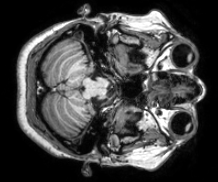

In [11]:
TT.ToPILImage()(dataset_B[200]['img'])

In [7]:
pseudo_df = dataset_B.df
pseudo_df['pseudo_mask'] = ''
pseudo_df.head(5)

,img,mask,file_id,domain,pseudo_mask
0,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,
1,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,
2,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,
3,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,
4,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,


In [9]:
from tqdm.notebook import tqdm
from PIL import Image
import torch
import os

num_classes = 2

with torch.no_grad():

    # preds = torch.zeros((len(dataset_B), 182, 218))
    # labels = torch.zeros((len(dataset_B), 182, 218))

    # for i, _ in tqdm(enumerate(dataset_B), total=len(dataset_B)):

    #     img = dataset_B[i]['img'].unsqueeze(0).cuda()
    #     mask = dataset_B[i]['mask'].squeeze()
    #     out = torch.zeros((1, num_classes, img.shape[-2], img.shape[-1])) 

    #     for model in models_list:
    #         out += model(img).cpu() / len(models_list)

    #     labels[i] = torch.argmax(out, dim=1).squeeze().float()
    #     preds[i] = torch.max(out, dim=1).values.squeeze().float()

    # thres = torch.zeros(num_classes)

    # for i in range(num_classes):
    #     x = preds[labels==i]
    #     if len(x) != 0:        
    #         thres[i] = torch.topk(x, k=int(len(x) * 0.34))[0][-1]

    # thres[thres > 0.9] = 0.9
    
    for sample_id, _ in tqdm(enumerate(dataset_B), total=len(dataset_B)):
        label = labels[sample_id]
        prob = preds[sample_id]
        for i in range(num_classes):
            label[   (prob<thres[i]) * (label==i)   ] = 255  
        output = np.asarray(label, dtype=np.uint8)
        output = Image.fromarray(output)

        f_path = f'pseudo_masks/mask_{sample_id}.png'
        pseudo_df.at[sample_id, 'pseudo_mask'] = f'{os.getcwd()}/{f_path}'
        im = TT.ToPILImage()(label)
        im.save(f_path, 'PNG')
        # break

  0%|          | 0/10320 [00:00<?, ?it/s]

In [11]:
pseudo_df.to_csv('pseudo_df.csv')
pseudo_df.head(5)

,img,mask,file_id,domain,pseudo_mask
0,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,/home/v_chernyy/thesis/pseudo_masks/mask_0.png
1,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,/home/v_chernyy/thesis/pseudo_masks/mask_1.png
2,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,/home/v_chernyy/thesis/pseudo_masks/mask_2.png
3,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,/home/v_chernyy/thesis/pseudo_masks/mask_3.png
4,/raid/data/DA_BrainDataset/philips3/train/CC01...,/raid/data/DA_BrainDataset/philips3/mask/CC010...,CC0109,philips_3,/home/v_chernyy/thesis/pseudo_masks/mask_4.png


In [12]:
!pwd

/home/v_chernyy/thesis
